In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import os
from torchvision import transforms as tfs
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

In [2]:
transform = tfs.Compose([
    tfs.CenterCrop(512),
    tfs.Resize(128),
    tfs.ToTensor(),
    tfs.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [3]:
PortraitSet = ImageFolder('./img_jpg', transform = transform)
PortraitData = DataLoader(PortraitSet, batch_size = 128, shuffle = True, num_workers = 2)

In [4]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

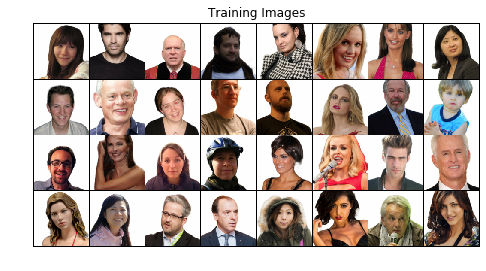

In [5]:
real_batch = next(iter(PortraitData))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
class Generator_128(nn.Module):
    def __init__(self):
        super(Generator_128, self).__init__()
        self.deconv1 = nn.Sequential(
                        nn.ConvTranspose2d(100, 64*8, 4, 1, 0, bias=False),
                        nn.BatchNorm2d(64*8),
                        nn.ReLU(True))
        self.deconv1.requires_grad = False
        
        self.deconv2 = nn.Sequential(
                        nn.ConvTranspose2d(64*8, 64* 6, 4, 2, 1, bias = False),
                        nn.BatchNorm2d(64*6),
                        nn.ReLU(True))
        self.deconv2.requires_grad = False
        
        self.deconv3 = nn.Sequential(
                        nn.ConvTranspose2d(64*6, 64*5, 4, 2, 1, bias = False),
                        nn.BatchNorm2d(64*5),
                        nn.ReLU(True))
        self.deconv3.requires_grad = False
        
        self.deconv4 = nn.Sequential(
                        nn.ConvTranspose2d(64*5, 64*4, 4, 2, 1, bias = False),
                        nn.BatchNorm2d(64*4),
                        nn.ReLU(True))
        self.deconv4.requires_grad = False
        
        self.deconv5 = nn.Sequential(
                        nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias = False),
                        nn.BatchNorm2d(64*2),
                        nn.ReLU(True))
        self.deconv5.requires_grad = False
        self.deconv6 = nn.Sequential(
                        nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias = False),
                        nn.BatchNorm2d(64), 
                        nn.ReLU(True))
        
        
        self.skip_conv5 = nn.Sequential(
                            nn.Conv2d(64, 64, 3, 1, 1),
                            nn.BatchNorm2d(64),
                            nn.ReLU(True))
        
        self.change_c_128 = nn.Sequential(
                        nn.Conv2d(64, 3, 1, 1),
                        nn.Tanh())
        
    def forward(self, x):
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.deconv5(x)
        x1 = self.deconv6(x)
        x2 = self.skip_conv5(x1)
        x1_rgb = self.change_c_128(x1)
        x2_rgb = self.change_c_128(x2)
        return torch.add(x1_rgb, x2_rgb)

In [7]:
class Discriminator_128(nn.Module):
    def __init__(self):
        super(Discriminator_128, self).__init__()
        self.conv1 = nn.Sequential(
                    nn.Conv2d(64*16, 1, 4, 1, 0, bias = False),
                    nn.Sigmoid())
        self.conv1.requires_grad = False
        
        self.conv2 = nn.Sequential(
                    nn.Conv2d(64*8, 64*16, 4, 2, 1, bias = False),
                    nn.BatchNorm2d(64*16),
                    nn.LeakyReLU(0.2, inplace = True))
        self.conv2.requires_grad = False
        
        self.conv3 = nn.Sequential(
                    nn.Conv2d(64*6, 64*8, 4, 2, 1, bias = False),
                    nn.BatchNorm2d(64*8),
                    nn.LeakyReLU(0.2, inplace = True))
        self.conv3.requires_grad = False
        
        self.conv4 = nn.Sequential(
                    nn.Conv2d(64*5,64*6, 4, 2, 1, bias = False),
                    nn.BatchNorm2d(64*6),
                    nn.LeakyReLU(0.2, inplace = True))
        self.conv4.requires_grad = False
        
        self.conv5 = nn.Sequential(
                    nn.Conv2d(64*4, 64*5, 4, 2, 1, bias = False),
                    nn.BatchNorm2d(64*5),
                    nn.LeakyReLU(0.2, inplace = True))
        self.conv5.requires_grad = False
        
        self.conv6 = nn.Sequential(
                    nn.Conv2d(64*2, 64*4, 4, 2, 1, bias = False),
                    nn.BatchNorm2d(64*4),
                    nn.LeakyReLU(0.2, inplace = True))
        
        
        self.skip_conv5 = nn.Sequential(
                        nn.Conv2d(64*2, 64*2, 3, 1, 1),
                        nn.BatchNorm2d(64*2),
                        nn.ReLU(True))
        
        
        self.change_c_128 = nn.Sequential(
                        nn.Conv2d(3, 64*2, 1, 1),
                        nn.BatchNorm2d(64*2),
                        nn.LeakyReLU(0.2, inplace=True))
    
    def forward(self, x):
        x1 = self.change_c_128(x)
        x1 = self.conv6(x1)
        x2 = self.change_c_128(x)
        x2 = self.skip_conv5(x2)
        x2 = self.conv6(x2)
        x = x1 + x2
        
        x = self.conv5(x)
        x = self.conv4(x)
        x = self.conv3(x)
        x = self.conv2(x)
        x = self.conv1(x)
        return x

In [8]:
G_net = Generator_128()
D_net = Discriminator_128()
G_net = nn.DataParallel(G_net)
D_net = nn.DataParallel(D_net)
G_net.to(device)
D_net.to(device)


G_optim = torch.optim.Adam(G_net.parameters(), lr = 0.0005, betas = (0.5, 0.999))
D_optim = torch.optim.Adam(D_net.parameters(), lr = 0.0005, betas = (0.5, 0.999))

In [9]:
G_net_128_pre = torch.load('Generator_128_2.pkl')
G_net.load_state_dict(G_net_128_pre)
D_net_128_pre = torch.load('Discriminator_128_2.pkl')
D_net.load_state_dict(D_net_128_pre)

In [ ]:
# Generator_64 = torch.load('Generator_64_3.pkl')
# Generator_128_dict = G_net.state_dict()
# pretrained_dict = {k:v for k,v in Generator_64.items() if k in Generator_128_dict}
# Generator_128_dict.update(pretrained_dict)
# G_net.load_state_dict(Generator_128_dict)

In [ ]:
# Discriminator_64 = torch.load('Discriminator_64_3.pkl')
# Discriminator_128_dict = D_net.state_dict()
# pretrained_dict = {k:v for k,v in Discriminator_64.items() if k in Discriminator_128_dict}
# Discriminator_128_dict.update(pretrained_dict)
# D_net.load_state_dict(Discriminator_128_dict)

In [10]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
real_label = 1
fake_label = 0
epoch = 20

In [11]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epo in range(epoch):
    for i, data in enumerate(PortraitData, 0):
        real_data = data[0].to(device)
        b_size = real_data.size(0)
        label = torch.full((b_size,), real_label, device = device)
        output = D_net(real_data).view(-1)
        real_error = criterion(output, label)
        D_optim.zero_grad()
        real_error.backward()
        D_x = output.mean().item()
        
        noise = torch.randn(b_size, 100, 1, 1,device = device)
        fake_data = G_net(noise)
        label.fill_(fake_label)
        output = D_net(fake_data.detach()).view(-1)
        fake_error = criterion(output, label)
        fake_error.backward()
        D_G_z1 = output.mean().item()
        err_D = real_error + fake_error
        D_optim.step()
        
        label.fill_(real_label)
        output = D_net(fake_data).view(-1)
        err_G = criterion(output, label)
        G_optim.zero_grad()
        err_G.backward()
        D_G_z2 = output.mean().item()
        G_optim.step()
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epo, epoch, i, len(PortraitData),
                     err_D.item(), err_G.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(err_G.item())
        D_losses.append(err_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epo == epoch-1) and (i == len(PortraitData)-1)):
            with torch.no_grad():
                fake = G_net(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1        

[0/20][0/269]	Loss_D: 0.0807	Loss_G: 8.0132	D(x): 0.9869	D(G(z)): 0.0538 / 0.0007
[0/20][50/269]	Loss_D: 0.6541	Loss_G: 2.4727	D(x): 0.6272	D(G(z)): 0.0072 / 0.2475
[0/20][100/269]	Loss_D: 0.0239	Loss_G: 6.6555	D(x): 0.9917	D(G(z)): 0.0143 / 0.0038
[0/20][150/269]	Loss_D: 0.0941	Loss_G: 5.8624	D(x): 0.9472	D(G(z)): 0.0280 / 0.0126
[0/20][200/269]	Loss_D: 0.0379	Loss_G: 5.5345	D(x): 0.9912	D(G(z)): 0.0263 / 0.0125
[0/20][250/269]	Loss_D: 0.1017	Loss_G: 4.6894	D(x): 0.9481	D(G(z)): 0.0395 / 0.0290
[1/20][0/269]	Loss_D: 0.0710	Loss_G: 5.2780	D(x): 0.9625	D(G(z)): 0.0254 / 0.0160
[1/20][50/269]	Loss_D: 0.0422	Loss_G: 5.8441	D(x): 0.9986	D(G(z)): 0.0373 / 0.0077
[1/20][100/269]	Loss_D: 0.0611	Loss_G: 6.1796	D(x): 0.9971	D(G(z)): 0.0490 / 0.0073
[1/20][150/269]	Loss_D: 0.1314	Loss_G: 6.0737	D(x): 0.9850	D(G(z)): 0.0877 / 0.0057
[1/20][200/269]	Loss_D: 0.1221	Loss_G: 5.3460	D(x): 0.9923	D(G(z)): 0.0885 / 0.0117
[1/20][250/269]	Loss_D: 0.1683	Loss_G: 3.4648	D(x): 0.8836	D(G(z)): 0.0197 / 0.088

[16/20][100/269]	Loss_D: 0.0449	Loss_G: 7.7280	D(x): 0.9610	D(G(z)): 0.0026 / 0.0029
[16/20][150/269]	Loss_D: 0.0113	Loss_G: 8.6670	D(x): 0.9981	D(G(z)): 0.0089 / 0.0019
[16/20][200/269]	Loss_D: 0.0663	Loss_G: 5.4624	D(x): 0.9683	D(G(z)): 0.0286 / 0.0160
[16/20][250/269]	Loss_D: 0.0131	Loss_G: 7.6857	D(x): 0.9948	D(G(z)): 0.0073 / 0.0038
[17/20][0/269]	Loss_D: 0.0206	Loss_G: 6.9113	D(x): 0.9849	D(G(z)): 0.0048 / 0.0054
[17/20][50/269]	Loss_D: 0.0332	Loss_G: 6.6881	D(x): 0.9724	D(G(z)): 0.0044 / 0.0048
[17/20][100/269]	Loss_D: 0.0878	Loss_G: 6.2493	D(x): 0.9893	D(G(z)): 0.0660 / 0.0085
[17/20][150/269]	Loss_D: 0.0833	Loss_G: 6.0288	D(x): 0.9449	D(G(z)): 0.0079 / 0.0111
[17/20][200/269]	Loss_D: 0.1258	Loss_G: 5.0948	D(x): 0.9030	D(G(z)): 0.0091 / 0.0316
[17/20][250/269]	Loss_D: 0.0143	Loss_G: 6.6912	D(x): 0.9952	D(G(z)): 0.0090 / 0.0056
[18/20][0/269]	Loss_D: 0.0493	Loss_G: 6.3269	D(x): 0.9992	D(G(z)): 0.0422 / 0.0094
[18/20][50/269]	Loss_D: 0.0105	Loss_G: 7.0214	D(x): 0.9995	D(G(z)): 0.

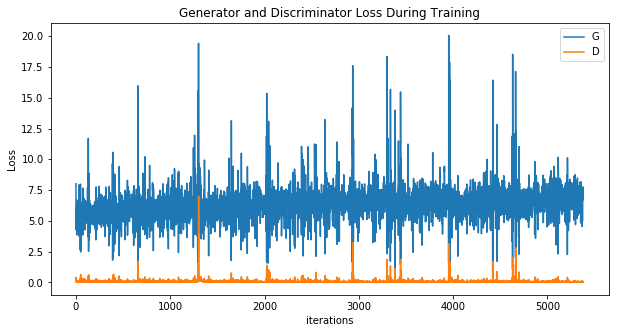

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

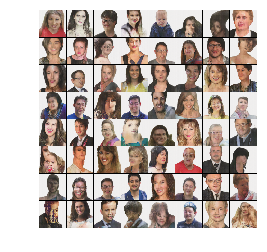

In [13]:
from IPython.display import HTML
fig = plt.figure(figsize=(8,4))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [14]:
torch.save(G_net.state_dict(), 'Generator_128_3.pkl')
torch.save(D_net.state_dict(), 'Discriminator_128_3.pkl')